# Text to sequence data

For this chapter, we will extract character sequences from H. G. Wells' [*The Time Machine*](http://www.gutenberg.org/ebooks/35), a book containing just over 30,000 words. While real applications will typically involve significantly larger datasets, this is sufficient to demonstrate the preprocessing pipeline.

In [1]:
!mkdir ./data
!curl "https://www.gutenberg.org/cache/epub/35/pg35.txt" --output ./data/time_machine.txt

mkdir: ./data: File exists
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  199k  100  199k    0     0   103k      0  0:00:01  0:00:01 --:--:--  103k


This has some boilerplate text by [Project Gutenberg](https://www.gutenberg.org/)[^1] that we have to remove:

[^1]: Project Gutenberg is an excellent source of literary text data. Moreover, the preprocessing steps for `.txt` files are the same for each text.

In [2]:
text = open("./data/time_machine.txt").read()
text[:300]

'\ufeffThe Project Gutenberg eBook of The Time Machine\n    \nThis ebook is for the use of anyone anywhere in the United States and\nmost other parts of the world at no cost and with almost no restrictions\nwhatsoever. You may copy it, give it away or re-use it under the terms\nof the Project Gutenberg License'

Data cleaning:

In [3]:
import re

start = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
end = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
text = text[text.find(start) + len(start): text.find(end)]
text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
print(len(text.split()))
print(text[:100])
print(text[-100:])

32895
the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man


<br>

## Tokenization

Tokens are the *atomic* units of text. Each time step corresponds to 1 token, but what precisely constitutes a token is a design choice. For example, we could represent the sentence "Deep learning is fun" as a sequence of 4 tokens with 1 token for every word. Then, the set of all words comprise a large vocabulary (typically ~10-100K words). 
Or we can represent the same sentence as a much longer sequence of 30 characters, using a much smaller vocabulary (256 ASCII characters). There is some tradeoff associated with the choice of vocabulary[^2]. 

The **vocabulary** class below implements sort of a dictionary that maps `token` $\mapsto$ `index`. It also offers utilities such as inversion with `.to_tokens`, handling unknown and rare tokens, etc. Our implementation separates the vocabulary from the **tokenizer**, which is used to convert from text to token list and vice-versa.

[^2]: For example, using a larger vocabulary provides richer, context-aware understanding compared to ASCII-based tokenization. ASCII-only tokenization, such as treating each character as a token, loses essential semantic and syntactic information. Tokenization has [profound implications](https://x.com/karpathy/status/1759996551378940395) which we will cover in a future chapter.

In [4]:
%%save
import collections

class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itot = ["<unk>"] + list(sorted(set(
            reserved_tokens +   # i.e. not subject to min_freq
            [token for token, freq in self.token_freqs if freq >= min_freq]
        )))
        self.ttoi = {tok: idx for idx, tok in enumerate(self.itot)}

    def __len__(self):
        return len(self.itot)
    
    def __getitem__(self, tokens: list[str]) -> list[int]:
        if isinstance(tokens, (list, tuple)):
            return [self.__getitem__(tok) for tok in tokens]
        else:
            return self.ttoi.get(tokens, self.unk)
            
    def to_tokens(self, indices) -> list[str]:
        if hasattr(indices, "__len__"):
            return [self.itot[int(index)] for index in indices]
        else:
            return self.itot[indices]

    @property
    def unk(self) -> int:
        return self.ttoi["<unk>"]

import collections

class Vocab:
    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        self.itot = ["<unk>"] + list(sorted(set(
            reserved_tokens +   # i.e. not subject to min_freq
            [token for token, freq in self.token_freqs if freq >= min_freq]
        )))
        self.ttoi = {tok: idx for idx, tok in enumerate(self.itot)}

    def __len__(self):
        return len(self.itot)
    
    def __getitem__(self, tokens: list[str]) -> list[int]:
        if isinstance(tokens, (list, tuple)):
            return [self.__getitem__(tok) for tok in tokens]
        else:
            return self.ttoi.get(tokens, self.unk)
            
    def to_tokens(self, indices) -> list[str]:
        if hasattr(indices, "__len__"):
            return [self.itot[int(index)] for index in indices]
        else:
            return self.itot[indices]

    @property
    def unk(self) -> int:
        return self.ttoi["<unk>"]

Here we tokenize our preprocessed text into a sequence of characters:


In [5]:
tokens = list(text)
", ".join(tokens[:42])  # 42

't, h, e,  , t, i, m, e,  , m, a, c, h, i, n, e,  , a, n,  , i, n, v, e, n, t, i, o, n,  , b, y,  , h,  , g,  , w, e, l, l, s'

The *corpus* is just the tokens encoded to integers. Since the mapping is 1-1, we can just think of the corpus as the sequence of tokens.

In [6]:
vocab = Vocab(tokens)
corpus = vocab[tokens]

assert len(set(corpus)) + 1 == len(vocab)
print(len(vocab))
print(len(corpus))
print(vocab.token_freqs[:3], "...", vocab.token_freqs[-3:])
print(vocab["h", "e", "l", "l", "o", "Q"])
print(vocab.to_tokens(corpus[:16]))

28
174215
[(' ', 32894), ('e', 17918), ('t', 13591)] ... [('z', 106), ('j', 97), ('q', 95)]
[9, 6, 13, 13, 16, 0]
['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm', 'a', 'c', 'h', 'i', 'n', 'e']


Defining the class for processing the dataset:

In [7]:
%%save
import re
import os
import requests


class TimeMachine:
    def __init__(self, download=False, token_level="char"):
        self.token_level = token_level
        self.filepath = "./data/time_machine.txt"
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _preprocess(self, text: str):
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    def tokenize(self, text: str):
        return list(text) if self.token_level == "char" else text.split()
        
    def build(self, vocab=None):
        with open(self.filepath, "r") as f:
            raw_text = f.read()
        
        self.text = self._preprocess(raw_text)
        self.tokens = self.tokenize(self.text) 
        
        vocab = Vocab(self.tokens) if vocab is None else vocab
        corpus = vocab[self.tokens]
        return corpus, vocab

import re
import os
import requests


class TimeMachine:
    def __init__(self, download=False, token_level="char"):
        self.token_level = token_level
        self.filepath = "./data/time_machine.txt"
        if download or not os.path.exists(self.filepath):
            self._download()
        
    def _download(self):
        url = "https://www.gutenberg.org/cache/epub/35/pg35.txt"
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(self.filepath, "wb") as output:
            output.write(response.content)
        
    def _preprocess(self, text: str):
        s = "*** START OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        e = "*** END OF THE PROJECT GUTENBERG EBOOK THE TIME MACHINE ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    def tokenize(self, text: str):
        return list(text) if self.token_level == "char" else text.split()
        
    def build(self, vocab=None):
        with open(self.filepath, "r") as f:
            raw_text = f.read()
        
        self.text = self._preprocess(raw_text)
        self.tokens = self.tokenize(self.text) 
        
        vocab = Vocab(self.tokens) if vocab is None else vocab
        corpus = vocab[self.tokens]
        return corpus, vocab

Basic usage starts with download and then build:

In [8]:
tm = TimeMachine(download=True)
corpus, vocab = tm.build()

In [9]:
print(type(tm.text))
print(tm.text[:100])
print(tm.text[-100:])
print(len(corpus), len(vocab))

<class 'str'>
the time machine an invention by h g wells contents i introduction ii the machine iii the time trave
when mind and strength had gone gratitude and a mutual tenderness still lived on in the heart of man
174215 28


Trying out the `<unk>` token for unknown characters:

In [10]:
vocab.to_tokens(vocab[tm.tokenize("$w@gger")])

['<unk>', 'w', '<unk>', 'g', 'g', 'e', 'r']

<br>

## Appendix: Project Gutenberg Reader

In this section, we generalize the `TimeMachine` class to read any title in Project Gutenberg.

In [11]:
%%save
import re
import os
import requests

ENCODING = "utf-8-sig"


class ProjectGutenberg:
    def __init__(self, url: str, data_dir: str, download=False, token_level="char"):
        self.token_level = token_level
        self.filepath = f"{data_dir}/{url.split('/')[-1]}"
        if download or not os.path.exists(self.filepath):
            self.download(url, self.filepath)

    @staticmethod
    def get_title(filepath):
        with open(filepath, "r", encoding=ENCODING) as f:
            line = f.readline()
        prefix = "The Project Gutenberg eBook of"
        return line.replace(prefix, "").strip()

    @staticmethod
    def download(url, filepath):
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(filepath, "wb") as output:
            output.write(response.content)
        
    @staticmethod
    def preprocess(text: str, title: str):
        s = f"*** START OF THE PROJECT GUTENBERG EBOOK {title.upper()} ***"
        e = f"*** END OF THE PROJECT GUTENBERG EBOOK {title.upper()} ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    @staticmethod
    def tokenize(text: str, token_level="char"):
        return list(text) if token_level == "char" else text.split()

    def build(self, vocab=None):
        with open(self.filepath, "r", encoding=ENCODING) as f:
            raw_text = f.read()
        
        self.title = self.get_title(self.filepath)
        self.text = self.preprocess(raw_text, self.title)
        self.tokens = self.tokenize(self.text, self.token_level)

        vocab = Vocab(self.tokens) if vocab is None else vocab
        corpus = vocab[self.tokens]
        return corpus, vocab

import re
import os
import requests

ENCODING = "utf-8-sig"


class ProjectGutenberg:
    def __init__(self, url: str, data_dir: str, download=False, token_level="char"):
        self.token_level = token_level
        self.filepath = f"{data_dir}/{url.split('/')[-1]}"
        if download or not os.path.exists(self.filepath):
            self.download(url, self.filepath)

    @staticmethod
    def get_title(filepath):
        with open(filepath, "r", encoding=ENCODING) as f:
            line = f.readline()
        prefix = "The Project Gutenberg eBook of"
        return line.replace(prefix, "").strip()

    @staticmethod
    def download(url, filepath):
        print(f"Downloading text from {url} ...", end=" ")
        response = requests.get(url, stream=True)
        response.raise_for_status()
        print("OK!")
        with open(filepath, "wb") as output:
            output.write(response.content)
        
    @staticmethod
    def preprocess(text: str, title: str):
        s = f"*** START OF THE PROJECT GUTENBERG EBOOK {title.upper()} ***"
        e = f"*** END OF THE PROJECT GUTENBERG EBOOK {title.upper()} ***"
        text = text[text.find(s) + len(s): text.find(e)]
        text = re.sub('[^A-Za-z]+', ' ', text).lower().strip()
        return text
    
    @staticmethod
    def tokenize(text: str, token_level="char"):
        return list(text) if token_level == "char" else text.split()

    def build(self, vocab=None):
        with open(self.filepath, "r", encoding=ENCODING) as f:
            raw_text = f.read()
        
        self.title = self.get_title(self.filepath)
        self.text = self.preprocess(raw_text, self.title)
        self.tokens = self.tokenize(self.text, self.token_level)

        vocab = Vocab(self.tokens) if vocab is None else vocab
        corpus = vocab[self.tokens]
        return corpus, vocab

The list of [most downloaded books](https://www.gutenberg.org/browse/scores/top) can be obtained by web scraping:

In [12]:
%%save
import requests
from bs4 import BeautifulSoup

def get_top100_books():
    url = "https://www.gutenberg.org/browse/scores/top#books-last30"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # scraping Top 100 EBooks yesterday section
    header = soup.find(id="books-last1")
    booklist = header.find_next("ol").find_all("a", href=True)

    # build url for plain text files
    text_urls = []
    base_url = "https://www.gutenberg.org"
    for link in booklist:
        idx = link["href"].split("/")[-1]
        text_urls.append(f"{base_url}/cache/epub/{idx}/pg{idx}.txt")

    return text_urls

import requests
from bs4 import BeautifulSoup

def get_top100_books():
    url = "https://www.gutenberg.org/browse/scores/top#books-last30"
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    # scraping Top 100 EBooks yesterday section
    header = soup.find(id="books-last1")
    booklist = header.find_next("ol").find_all("a", href=True)

    # build url for plain text files
    text_urls = []
    base_url = "https://www.gutenberg.org"
    for link in booklist:
        idx = link["href"].split("/")[-1]
        text_urls.append(f"{base_url}/cache/epub/{idx}/pg{idx}.txt")

    return text_urls

In [13]:
urls = get_top100_books()
print(len(urls))
urls[:10]

100


['https://www.gutenberg.org/cache/epub/25558/pg25558.txt',
 'https://www.gutenberg.org/cache/epub/84/pg84.txt',
 'https://www.gutenberg.org/cache/epub/2701/pg2701.txt',
 'https://www.gutenberg.org/cache/epub/1513/pg1513.txt',
 'https://www.gutenberg.org/cache/epub/100/pg100.txt',
 'https://www.gutenberg.org/cache/epub/145/pg145.txt',
 'https://www.gutenberg.org/cache/epub/2641/pg2641.txt',
 'https://www.gutenberg.org/cache/epub/11/pg11.txt',
 'https://www.gutenberg.org/cache/epub/37106/pg37106.txt',
 'https://www.gutenberg.org/cache/epub/1342/pg1342.txt']

Reading the first book from this list:

In [14]:
url = urls[0]
book = ProjectGutenberg(url=url, data_dir="./data")
corpus, vocab = book.build()

print("Title:", book.title)
print("Word count:", len(book.text.split()))
print("Character count:", len(corpus))
print("\nExcerpt:")
print("  ", book.text[:80])
print("  ", "...")
print("  ", book.text[-80:])

Title: 呻吟語
Word count: 5
Character count: 24

Excerpt:
   produced by chu yu huang
   ...
   produced by chu yu huang


<br>

## Appendix: Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law) is an empirical law which states that 
the frequency $f_i$ of the $i$-th most frequent word for texts in natural language decays inversely proportional to its word rank $i,$ after a few exceptions. Let $a > 0$ characterize the rate of token frequency decay. Then,

$$f_i = \frac{f_1} {i^{a}}$$

or

$$\log f_i = -a \log i + \log f_1.$$

Note that the indexing drops a few words, i.e. $i = 1$ corresponds to the rank of the first word that wasn't dropped. The parameter $a$ and the number of skipped words is particular to the text and, to a larger scale, the language used.

In [15]:
# loading Frankenstein
url = "https://www.gutenberg.org/cache/epub/84/pg84.txt"
book = ProjectGutenberg(url=url, data_dir="./data")
corpus, vocab = book.build()

words = book.tokenize(book.text, token_level="word")
word_freqs = Vocab(words).token_freqs
bigram_freqs = Vocab(["__".join(pair) for pair in zip(words[:-1], words[1:])]).token_freqs
trigram_freqs = Vocab(["__".join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])]).token_freqs

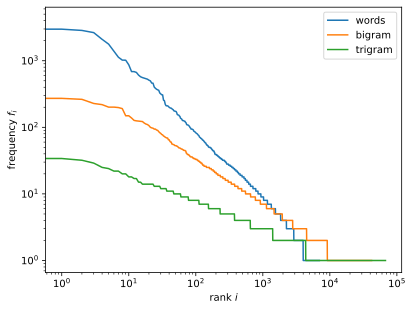

In [16]:
%matplotlib inline
%config InlineBackend.figure_format = "svg"
import matplotlib.pyplot as plt

plt.plot([freq for _, freq in word_freqs], label="words")
plt.plot([freq for _, freq in bigram_freqs], label="bigram")
plt.plot([freq for _, freq in trigram_freqs], label="trigram")
plt.yscale("log")
plt.xscale("log")
plt.ylabel("frequency $f_i$")
plt.xlabel("rank $i$")
plt.legend();

Estimating $a$:

In [17]:
import math

print("1:", (math.log(word_freqs[100][1]) - math.log(word_freqs[10][1])) / (math.log(100) - math.log(10)))
print("2:", (math.log(bigram_freqs[100][1]) - math.log(bigram_freqs[10][1])) / (math.log(100) - math.log(10)))
print("3:", (math.log(trigram_freqs[100][1]) - math.log(trigram_freqs[10][1])) / (math.log(100) - math.log(10)))

1: -1.0194416328004179
2: -0.6546723285343865
3: -0.3521825181113625


**Remark.** Similar behavior and similar $a$'s have been observed for other novels. For example, *The Time Machine* and *Frankenstein* have similar values. Other types such as non-fiction or plays (*Romeo and Juliet*) have slightly but significantly different values.